In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

## Lectura de datos

El primer paso después de importar las librerías es leer las bases de datos, en esta encuesta tenemos varias de ellas, pero sólo vamos a utilizar cinco. La encuesta la podemos descargar en [este link](https://www.inegi.org.mx/programas/enigh/nc/2020/#Datos_abiertos). 

*Nota: Después de descargar la encuesta copiela a la carpeta donde está este código, descomprímala y copie los archivos a la carpeta "ENIGH2020", de no existir creela. 
Puede que tenga que cambiar el/los directorio(s) por el correcto en su computadora ya que al cambiar de sistema operativo pueden modificarse detalles como la orientación de las barras "/". Para que el código funcione correctamente asegurate de que todos los directorios están correctos.*

Definimos el directorio base y luego los directorios de cada base de datos, las cuales leemos luego utiizando la función **read_csv**. Veamos cómo luce uno de estos dataframe: 

In [78]:
directorio_base = './ENIGH2020/'  
gastos = 'enigh2020_ns_gastoshogar_csv/gastoshogar.csv'
hogares = 'enigh2020_ns_hogares_csv/hogares.csv'
ingresos = 'enigh2020_ns_ingresos_csv/ingresos.csv'
poblacion = 'enigh2020_ns_poblacion_csv/poblacion.csv'
viviendas = 'enigh2020_ns_viviendas_csv/viviendas.csv'

df_gastos = pd.read_csv(directorio_base+gastos)
df_hogar = pd.read_csv(directorio_base+hogares)
df_ingresos = pd.read_csv(directorio_base+ingresos)
df_poblacion = pd.read_csv(directorio_base+poblacion)
df_trabajos = pd.read_csv(directorio_base+trabajos)
df_viviendas = pd.read_csv(directorio_base+viviendas)

df_viviendas.head()

,folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,antiguedad,antigua_ne,cocina,cocina_dor,cuart_dorm,...,tot_hom,tot_muj,tot_hog,ubica_geo,tam_loc,est_socio,est_dis,upm,factor,procaptar
0,100013605,2,8,10,3,,1,1,2,3,...,1,2,1,1001,1,3,2,1,190,0
1,100013606,1,8,10,3,12,,1,2,3,...,3,1,1,1001,1,3,2,1,190,0
2,100017801,1,8,10,3,,1,1,2,1,...,1,1,1,1001,1,3,2,2,189,0
3,100017802,1,8,10,3,,1,1,2,1,...,2,0,1,1001,1,3,2,2,189,0
4,100017803,1,8,10,3,20,,1,2,3,...,1,1,1,1001,1,3,2,2,189,0


## Selección de variables

Cada una tiene muchas variables que no serán de nuestro interés por ahora. La lista de variable que nos interesa fue guardada en un archivo excel llamado [Variables](https://docs.google.com/spreadsheets/d/1lesIPYyp3WEsZ1lf7W5qvuqC-uAXyJXU1RL0qjyLET0/edit?usp=sharing) que debería estar en la carpeta del directorio principal. Esta selección fue hecha mediante una revisión literaria. Además, vamos a seleccionar las variables identificadores, que son las que permiten identificar unas vivienda, hogar etc. y servirán para unir las bases de datos, usaremos un diccionario para guardar estas variables. A continuación, usaremos funcionalidades de los dataframes para seleccionar las variables que corresponden a cada base de datos y quedarnos con las columnas correspondientes a los identificadores y las variables de interés. 

In [79]:
variables = pd.read_excel('Variables.xlsx')

identificadores = {'vivienda':['folioviv'], 'hogar':['folioviv','foliohog'],
                   'ingresos':['folioviv','foliohog','numren','clave'],'gastos':['folioviv','foliohog','clave'],
                  'poblacion':['folioviv','foliohog','numren']}

# Vivienda
variables_vivienda = variables[variables['Base de datos']=='Vivienda']['Variable'].to_list()
df_viviendas = df_viviendas[identificadores['vivienda'] + variables_vivienda]

# Hogares
variables_hogar = variables[variables['Base de datos']=='Hogar']['Variable'].to_list()
df_hogar = df_hogar[identificadores['hogar'] + variables_hogar]

# Poblacion
variables_poblacion = variables[variables['Base de datos']=='Poblacion']['Variable'].to_list()
df_poblacion = df_poblacion[identificadores['poblacion'] + variables_poblacion]

# Gastos
variables_gastos = variables[variables['Base de datos']=='Gastos hogar']['Variable'].to_list()
df_gastos = df_gastos[identificadores['gastos'] + variables_gastos]

# Ingresos
variables_ingresos = variables[variables['Base de datos']=='Ingresos']['Variable'].to_list()
df_ingresos = df_ingresos[identificadores['ingresos'] + variables_ingresos]

## Unión de las bases de datos

### Viviendas y hogares

Nuestra unidad de análisis serán los hogares, pero algunas de las variables están a nivel vivienda, por lo tanto necesitamos unir ambas bases de datos, manteniendo todos los hogares. Utilizaremos la columna 'folioviv' para unir las bases, pero como puede haber varios hogares que correspondan a una misma vivienda y queremos mantener todos los hogares utilizamos el parámetro **how='right'**, lo cual hará que se mantengan todas las entradas de la base de la derecha en la función, en este caso df_hogar.  

In [80]:
df = df_viviendas.merge(df_hogar,on='folioviv',how='right')

### Gastos

Los gastos trimestrales por hogar vienen dados por tipo de gasto, pero queremos los gastos totales, por tanto necesitamos agrupar los datos por hogar y sumarlos. Primero exploremos la base de datos.

In [81]:
df_gastos.head()

,folioviv,foliohog,clave,gasto_tri
0,100013605,1,C001,108.0
1,100013605,1,C004,57.0
2,100013605,1,C005,69.0
3,100013605,1,C006,45.0
4,100013605,1,C015,96.0


Como vemos tiene cuatro columnas, sin embargo, la columna 'clave' no nos aporta información en los gastos totales, sino en el tipo de gasto, por eso la eliminaremos y luego veremos qué tipo de dato tenemos en la columna 'gasto_tri', y si hay datos en blanco.

In [82]:
df_gastos.drop(columns='clave',inplace=True)
print(df_gastos['gasto_tri'].dtype)
df_gastos[df_gastos['gasto_tri']==' ']

object


,folioviv,foliohog,gasto_tri
1989240,100021402,1,
1989241,100021402,1,
1989242,100021402,1,
1989243,100021402,1,
1989244,100021402,1,
...,...,...,...
4948439,3260770714,1,
4948440,3260770715,1,
4948441,3260770716,1,
4948442,3260770717,1,


Procederemos a eliminar estos renglones en blanco que no nos aportan ninguna información. Además convertiremos el tipo de datos de la columna 'gasto_tri' en _float_ con la función **astype**. Después, podemos utilizar la función **groupby** para agrupar los gastos por las columnas 'folioviv' y 'foliohog', identificadoras del hogar, y sumar para obtener los gastos totales. 

In [83]:
df_gastos = df_gastos[df_gastos['gasto_tri']!=' ']
df_gastos['gasto_tri'] = df_gastos['gasto_tri'].astype('float')
df_gastos = df_gastos.groupby(['folioviv','foliohog']).sum()

Finalmente uniremos esta base de datos con la que ya tenemos de viviendas y hogares. Como queremos mantener todos los hogares que teníamos, y en esta base quizás puedan faltar algunos usaremos esta vez el parámetro **how='left'** en la función **merge**.

In [84]:
df = df.merge(df_gastos,on=['folioviv','foliohog'],how='left')

### Ingresos

In [85]:
print(df_ingresos.head(),'\n')
print(df_ingresos['ing_tri'].dtype) #Como los datos son tipo "float" no necesitaremos cambiar el tipo de datos

    folioviv  foliohog  numren clave  ing_tri
0  100013605         1       1  P022  6295.08
1  100013605         1       1  P040   885.24
2  100013605         1       1  P049   491.80
3  100013605         1       1  P069  1573.77
4  100013605         1       2  P022  5409.83 

float64


Al explorar la base "Ingresos" vemos que tiene los ingresos trimestrales de varios tipos para cada persona del hogar, sin embargo, al ser el hogar nuestra unidad de medida, nos interesan los ingresos totales del hogar, por eso eliminaremos las columnas correspondientes a los identificadores de la persona y el tipo de ingreso y la agruparemos por hogar, sumando los valores de la columna, justo como hicimos anteriormente para la base "Gastos". Seguidamente, la uniremos al dataframe que estamos formando de la misma forma que hicimos con df_gastos.

In [86]:
df_ingresos.drop(columns=['numren','clave'],inplace=True)
df_ingresos = df_ingresos.groupby(['folioviv','foliohog']).sum()
df = df.merge(df_ingresos,on=['folioviv','foliohog'],how='left')

### Población

In [87]:
df_poblacion

,folioviv,foliohog,numren,atemed,alfabetism,trabajo_mp
0,100013605,1,1,1,1,1
1,100013605,1,2,1,1,2
2,100013605,1,3,2,1,2
3,100013606,1,1,1,1,1
4,100013606,1,2,2,1,2
...,...,...,...,...,...,...
315738,3260770717,1,6,2,1,2
315739,3260770717,1,7,2,2,
315740,3260770718,1,1,1,1,2
315741,3260770718,1,2,2,1,1


Como vemos en la base de "Población" tenemos varias variables como tipo de atención médica, alfabetismo y si la persona trabajó el mes pasado. Como estas variables son categóricas no podemos simplemente sumarlas para agruparlas por hogar. Más bien contaremos cuántas personas en el hogar responden sí o no a las preguntas sobre afiliación para atención médica, alfabetismo y empleo. Para ello cambiaremos en cada columna el valor 2, correspondiente a "No" por cero, para que al sumar contemos sólo aquellas personas que respondieron "Sí" dentro del hogar, pero antes necesitamos asegurarnos que todos los datos son tipo *int* o *float*.

In [88]:
print(df_poblacion['atemed'].unique())
print(df_poblacion['alfabetism'].unique())
print(df_poblacion['trabajo_mp'].unique())

[1 2 '1' '2' ' ']
['1' '2' ' ']
['1' '2' ' ']


Tenemos datos de tipo entero y cadenas. Y también datos vacíos. Eliminaremos los vacíos y convertiremos todos a *int* y a continuación sí podremos reemplazar y agrupar. Seguidamente eliminamos la columna del indicador "foliohog" que ya no se volverá a utilizar, sin embargo mantendremos la del indicador de vivienda, ya que está contiene información que nos será útil más adelante.

In [89]:
df_poblacion.drop(columns='numren',inplace=True)
for col in ['atemed','alfabetism','trabajo_mp']:
    df_poblacion = df_poblacion[df_poblacion[col]!=' ']
    df_poblacion[col] = df_poblacion[col].astype('int')
    df_poblacion[col].replace(2,0,inplace=True)

df_poblacion = df_poblacion.groupby(['folioviv','foliohog']).sum()
df = df.merge(df_poblacion,on=['folioviv','foliohog'],how='left')

df.drop(columns='foliohog',inplace=True)

## Transformación en las columnas

En algunas columnas hay variables codificadas con números. Sin embargo, aunque a la larga esto podría ser útil para el modelo que se implemente, queremos tener la información que corresponde a cada categoría. Para esto cargaremos nuevamente las variables pero ahora la tercera pestaña del cuaderno de excel correspondiente al diccionario de variables.

In [90]:
diccionario_df = pd.read_excel('Variables.xlsx',sheet_name='Diccionario de variables')

print('diccionario_df:',diccionario_df,'\n')
print('Columnas:',diccionario_df.columns,'\n')
print("diccionario_df['Unnamed: 40'] = ",diccionario_df.loc[0,'Unnamed: 40'],'\n')
print("diccionario_df['gasto_tri'] = ",diccionario_df.loc[0,'gasto_tri'],'\n')
print("diccionario_df['combustible'] = ",diccionario_df.loc[0,'combustible'],'\n')

diccionario_df:     ing_tri gasto_tri   acc_alim1   acc_alim2   acc_alim3   acc_alim4  \
0  Numerica  Numerica  1:Sí\n2:No  1:Sí\n2:No  1:Sí\n2:No  1:Sí\n2:No   

    acc_alim5   acc_alim6   acc_alim7   acc_alim8  ...  tinaco_azo tot_resid  \
0  1:Sí\n2:No  1:Sí\n2:No  1:Sí\n2:No  1:Sí\n2:No  ...  1:Sí\n2:No  Numerica   

    tot_hom   tot_muj   tot_hog    atemed alfabetism trabajo_mp Unnamed: 40  \
0  Numerica  Numerica  Numerica  Numerica   Numerica   Numerica         NaN   

                                    est_socio  
0  1:Bajo\n2:Medio bajo\n3:Medio alto\n4:Alto  

[1 rows x 42 columns] 

Columnas: Index(['ing_tri', 'gasto_tri', 'acc_alim1', 'acc_alim2', 'acc_alim3',
       'acc_alim4', 'acc_alim5', 'acc_alim6', 'acc_alim7', 'acc_alim8',
       'acc_alim9', 'acc_alim10', 'acc_alim11', 'acc_alim12', 'acc_alim13',
       'acc_alim14', 'acc_alim15', 'acc_alim16', 'celular', 'conex_inte',
       'num_auto', 'tipo_viv', 'mat_pared', 'mat_techos', 'mat_pisos',
       'cocina', 'num_c

Como vemos en este dataframe tenemos varios detalles a considerar, hay una columna totalmente vacía que será eliminada. Segundo, los caracteres "\n", provenientes de  cambiar de línea en excel, no es bien interpretada en Python, podemos cambiarla por un espacio o una coma de utilizando la función **str.replace** aplicable a series de pandas sin embargo de momento la dejaremos así ya que la utilizaremos más adelante.

Además, nuestro objetivo final es obtener un diccionario para cada variable categórica, ya que este se va a utilizar junto con la función **replace** para reemplazar la codificación de esas variables por su significado. Como vemos, casi tenemos la estructura de un diccionario en Python, sin embargo, faltan algunos detalles, por ejemplo toda nuestra entrada es una cadena, sin separación, para solucionar esto usaremos dos veces la función **split** de las cadenas, y separaremos primeramente en todas las columnas por el caraacter "\n", obteniendo una lista con cada entrada de nuestro diccionario, sin embargo, aún esas entradas son cadenas, así que necesitamos volver a separarlas utilizando ahora el separador ":". Así podemos obtener dos listas, una de las llaves (con lo que está antes de los dos puntos) y otra con los valores que tendrán (lo que está después de los dos puntos) y con esto formar nuestro diccionario. Como las variables numéricas no tienen estos caracteres se quedarán sin modificaciones. 

In [91]:
diccionario_df.drop(columns='Unnamed: 40',inplace=True)

In [92]:
diccionario = {}
for col in diccionario_df.columns: 
    if diccionario_df.loc[0,col] != 'Numerica':
        lista = diccionario_df.loc[0,col].split('\n')
        diccionario[col] = {lista[i].split(':')[0]:lista[i].split(':')[1] for i in range(len(lista))}
        
diccionario    

{'acc_alim1': {'1': 'Sí', '2': 'No'},
 'acc_alim2': {'1': 'Sí', '2': 'No'},
 'acc_alim3': {'1': 'Sí', '2': 'No'},
 'acc_alim4': {'1': 'Sí', '2': 'No'},
 'acc_alim5': {'1': 'Sí', '2': 'No'},
 'acc_alim6': {'1': 'Sí', '2': 'No'},
 'acc_alim7': {'1': 'Sí', '2': 'No'},
 'acc_alim8': {'1': 'Sí', '2': 'No'},
 'acc_alim9': {'1': 'Sí', '2': 'No'},
 'acc_alim10': {'1': 'Sí', '2': 'No'},
 'acc_alim11': {'1': 'Sí', '2': 'No'},
 'acc_alim12': {'1': 'Sí', '2': 'No'},
 'acc_alim13': {'1': 'Sí', '2': 'No'},
 'acc_alim14': {'1': 'Sí', '2': 'No'},
 'acc_alim15': {'1': 'Sí', '2': 'No'},
 'acc_alim16': {'1': 'Sí', '2': 'No'},
 'celular': {'1': 'Sí', '2': 'No'},
 'conex_inte': {'1': 'Sí', '2': 'No'},
 'tipo_viv': {'1': 'Casa independiente',
  '2': 'Departamento en edificio',
  '3': 'Vivienda en vecindad',
  '4': 'Vivienda en cuarto de azotea',
  '5': 'Local no construido para habitación'},
 'mat_pared': {'1': 'Material de desecho',
  '2': 'Lámina de cartón',
  '3': 'Lámina de asbesto o metálica',
  '4': '

Teniendo este diccionario podemos utilizar la función replace en cada columna para reemplazar la codificación de cada variable con su significado: 

In [93]:
for col in diccionario_df.columns: 
    if diccionario_df.loc[0,col] != 'Numerica':
        df[col] = df[col].astype('str')
        df[col].replace(diccionario[col],inplace=True)
        
df        

,folioviv,tipo_viv,mat_pared,mat_techos,mat_pisos,cocina,num_cuarto,disp_agua,excusado,combustible,...,acc_alim15,acc_alim16,celular,conex_inte,num_auto,gasto_tri,ing_tri,atemed,alfabetism,trabajo_mp
0,100013605,Departamento en edificio,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,6,Agua entubada dentro de la vivienda,Sí,Gas de tanque,...,No,No,Sí,Sí,0,22693.22,16229.49,2,3,1
1,100013606,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,5,Agua entubada dentro de la vivienda,Sí,Gas natural o de tubería,...,No,No,Sí,Sí,1,18931.42,23827.86,2,3,1
2,100017801,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,3,Agua entubada dentro de la vivienda,Sí,Gas de tanque,...,,,Sí,Sí,1,44520.13,37421.77,1,2,2
3,100017802,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,5,Agua entubada dentro de la vivienda,Sí,Gas de tanque,...,,,Sí,Sí,0,76500.43,71557.37,1,1,1
4,100017803,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,"Madera, mosaico u otro recubrimiento",Sí,4,Agua entubada dentro de la vivienda,Sí,Gas de tanque,...,,,Sí,Sí,1,30140.68,71803.26,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89001,3260770714,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Lámina metálica,Cemento o firme,Sí,4,Agua entubada dentro de la vivienda,Sí,Gas de tanque,...,,,Sí,No,0,6808.18,11803.26,0,2,1
89002,3260770715,Casa independiente,"Tabique, ladrillo, block, piedra, cantera, cem...",Losa de concreto o viguetas con bovedilla,Cemento o firme,Sí,3,Agua entubada dentro de la vivienda,Sí,Gas de tanque,...,,,Sí,No,0,9845.39,15304.89,0,2,2
89003,3260770716,Casa independiente,Adobe,Lámina metálica,Cemento o firme,Sí,4,Agua entubada dentro de la vivienda,No,Gas de tanque,...,No,No,No,No,0,5462.66,8704.91,0,1,2
89004,3260770717,Casa independiente,Adobe,Losa de concreto o viguetas con bovedilla,Cemento o firme,Sí,6,Agua entubada dentro de la vivienda,Sí,Gas de tanque,...,,,Sí,Sí,0,18892.14,22967.20,0,6,2


## Imputación

En las columnas "tipo_viv" y "mat_pisos" hay varias entradas con el símbolo &, el cual representa un dato no especificado. Estos no nos servirán para el análisis, hay varias formas de tratar estos datos, simplemente removerlos o cambiarlos por otro valor que tenga sentido en la base de datos. Veamos cuántas entradas tienen este símbolo.  

In [94]:
print(df['tipo_viv'].value_counts())
print(df['mat_pisos'].value_counts())

Casa independiente                     84717
Departamento en edificio                2163
Vivienda en vecindad                    1445
Local no construido para habitación      504
&                                         95
Vivienda en cuarto de azotea              82
Name: tipo_viv, dtype: int64
Cemento o firme                         46956
Madera, mosaico u otro recubrimiento    39659
Tierra                                   2386
&                                           5
Name: mat_pisos, dtype: int64


Aunque en la columna "mat_pisos" hay sólo 5 casos con este símbolo, en la columna "tipo_viv" hay 95, que es un número ya un poco elevado, ya que estos casos pueden contener información en otras variables que nos ayude al análisis. Por lo tanto, no queremos eliminar estos casos y podemos aplicar una técnica llamada [imputación](https://repositorio.cepal.org/bitstream/handle/11362/4755/1/S0700590_es.pdf). En este caso utilizaremos la [imputación simple](https://scikit-learn.org/stable/modules/impute.html), la cual reemplaza el valor perdido por uno que depende de un criterio predeterminado y depende de la propia columna, en este caso utilizaremos el valor que más se repite.
Recordemos que Python no entiende que el carácter & no tiene valor para nosotros. Para la computadora es simplemente un valor más. Podríamos convertirlo en Nan, pero los programadores tuvieron una mejor idea e incluyeron en la función **SimpleImputer** el parámetro "missing_values" para que podamos especificar qué valor queremos imputar.   

In [95]:
imp = SimpleImputer(missing_values='&',strategy="most_frequent")
df[['tipo_viv','mat_pisos']] = imp.fit_transform(df[['tipo_viv','mat_pisos']])

Nota: Después de ejecutar la línea anterior regresa a imprimir el conteo de valores de las columnas y observa como han cambiado, desapareciendo el valor &.

## Creación de nuevos indicadores 

Observemos que en las columnas de nuestro dataframe tenemos las variables acc_alim1,acc_alim2,...,acc_alim16, las cuales se refierena a distintas preguntas acerca del acceso a alimentos como la preocupación porque la comida se acabe, la poca variedad de alimentos, entre otras. Estas variables probablemente presenten una muy alta correlación entre sí, sin embargo al ser una variable categórica no podemos calcular la correlación usual, si no que utilizaremos la prueba [Cramer's V](https://www.statology.org/cramers-v-in-python/)  

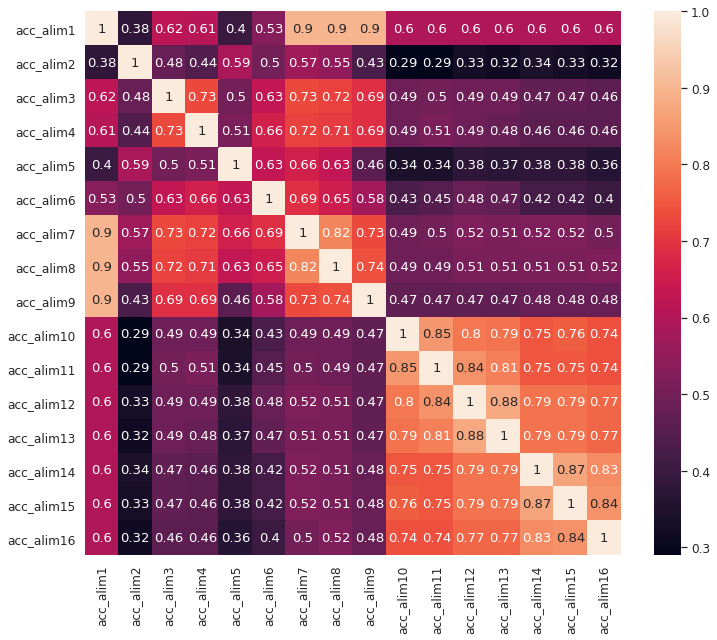

In [96]:
columns = df.columns[df.columns.to_list().index('acc_alim1'):df.columns.to_list().index('acc_alim16')+1]
correlations = pd.DataFrame(np.zeros((len(columns),len(columns))),index=columns,columns=columns)

for col1 in columns:
        for col2 in columns:
            if col1 == col2:
                correlations.loc[col1,col2] = 1
            else:
                data = df.groupby(by=[col1,col2]).size().reset_index().pivot(col1,col2,0)
                data.fillna(0,inplace=True)
                stat, p, dof, expected = chi2_contingency(data)
                n = np.sum(np.sum(data))
                minDim = min(data.shape)-1
                #calculate Cramer's V 
                V = np.sqrt((stat/n) / minDim)
                if p < 0.05:
                    correlations.loc[col1,col2] = round(V,2)

fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(correlations, annot=True)                        
plt.show()

Como esperábamos algunas correlaciones son bastante altas. Esto puede generar problemas en los modelos que usaremos más adelante, además nos deja con muchas variables que transmiten una información redundante. Por eso vamos a construir un indicador único sobre acceso a los alimentos. Utilizaremos la siguiente metodología: en el hogar se respondió "Sí" a alguna de las preguntas sobre escasez de alimentos, el indicador, que llamaremos "Escasez de alimentos" será "Sí". Para ello utilizaremos un ciclo y una condicional dentro de una lista por comprehensión, además de algunas herramientas de pandas. Como ya no utilizaremos las columnas sobre acceso a alimentos las eliminaremos. Recordemos que estaban guardadas en la lista columns.

In [97]:
df["Escasez de alimentos"] = ['Sí' if df.loc[i,'acc_alim1':'acc_alim16'].any() == 'Sí' else 'No' for i in df.index]
df.drop(columns=columns,inplace=True)
df.columns

Index(['folioviv', 'tipo_viv', 'mat_pared', 'mat_techos', 'mat_pisos',
       'cocina', 'num_cuarto', 'disp_agua', 'excusado', 'combustible',
       'regadera', 'fregadero', 'tinaco_azo', 'tot_resid', 'tot_hom',
       'tot_muj', 'est_socio', 'celular', 'conex_inte', 'num_auto',
       'gasto_tri', 'ing_tri', 'atemed', 'alfabetism', 'trabajo_mp',
       'Escasez de alimentos'],
      dtype='object')

La columna del identificador "folioviv" tiene información sobre la ubicación de la vivienda. En específico el primer o dos primeros dígitos corresponden a la entidad o estado y el dígito que sigue corresponde a el tipo de comunidad, rural o urbana, siendo el código 6 correspondiente a rural y cualquier otro a urbano. Vamos a construir una variable binaria que haga más explícita esta información. Para ello tomaremos el dígito correspondiente de la columna, la dificultad es saber si es el segundo o tercero en cada renglón. Seguidamente, veamos qué queda en la columna "Tipo de comunidad" que construiremos. 

In [98]:
df['Tipo de comunidad'] = ['0']*len(df.index)
#df['Tipo de comunidad'] = 
df['folioviv'] = df['folioviv'].astype('str')
for i in df.index:
    if len(df.loc[i,'folioviv']) == len(df.loc[0,'folioviv']):
        df.loc[i,'Tipo de comunidad'] = df.loc[i,'folioviv'][1]
    else:
        df.loc[i,'Tipo de comunidad'] = df.loc[i,'folioviv'][2]          

df.drop(columns='folioviv',inplace=True)        
df['Tipo de comunidad'].unique()        

array(['0', '6', '1', '2'], dtype=object)

Vemos que la nueva columna ahora tiene los dígitos 0,1,2,6 y queremos dejar solamente 0 para rural y 1 para urbano, por tanto vamos a reemplazar estos valores.

In [99]:
df['Tipo de comunidad'].replace(['6','0', '1', '2'],['Rural']+['Urbano']*3,inplace=True)  # Recordemos que así ['0']+['1']*3 obtenemos la lista [0,1,1,1]

Además, observemos que tenemos varias columnas, "número de cuartos", "número de autos", "atemed", "alfabetism" y "trabajo_mp" en las que no podemos decir que más sea mejor, sino que es relativo al número de habitantes del hogar. Para tener variables que proporcionen información más exacta, transformaremos las variables mencionadas en el radio "número de cuartos/número de habitantes del hogar", "número de autos/número de habitantes del hogar" etc., esto lo lograremos dividiendo estas columnas. 

In [100]:
for col in ["num_cuarto", "num_auto", "atemed", "alfabetism", "trabajo_mp"]:
    df[col] = df[col]/df['tot_resid']

## Exploración con Seaborn y outliers

Es importante hacer una observación de las variables para, entre otras cosas, verificar que esté todo en orden y eliminar posibles [outliers o valores extremos](https://www.varsitytutors.com/hotmath/hotmath_help/spanish/topics/outliers#:~:text=Un%20valor%20m%C3%A1s%20extremo%20(outlier,la%20mediana%20%2C%20o%20la%20moda%20.), primero, observemos las variables numéricas con [histogramas](https://www.superprof.es/apuntes/escolar/matematicas/estadistica/descriptiva/histograma.html)

Como los tipos de gráficos para variables numéricas y categóricas son diferentes, primero utilizaremos la función **select_dtypes** de pandas con diferentes parámetros para reconocer el tipo de variables.  

In [101]:
numerical = df.select_dtypes(include=np.number)
categorical = df.select_dtypes(exclude=np.number)

array([[<AxesSubplot:title={'center':'num_cuarto'}>,
        <AxesSubplot:title={'center':'tot_resid'}>,
        <AxesSubplot:title={'center':'tot_hom'}>,
        <AxesSubplot:title={'center':'tot_muj'}>],
       [<AxesSubplot:title={'center':'num_auto'}>,
        <AxesSubplot:title={'center':'gasto_tri'}>,
        <AxesSubplot:title={'center':'ing_tri'}>,
        <AxesSubplot:title={'center':'atemed'}>],
       [<AxesSubplot:title={'center':'alfabetism'}>,
        <AxesSubplot:title={'center':'trabajo_mp'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

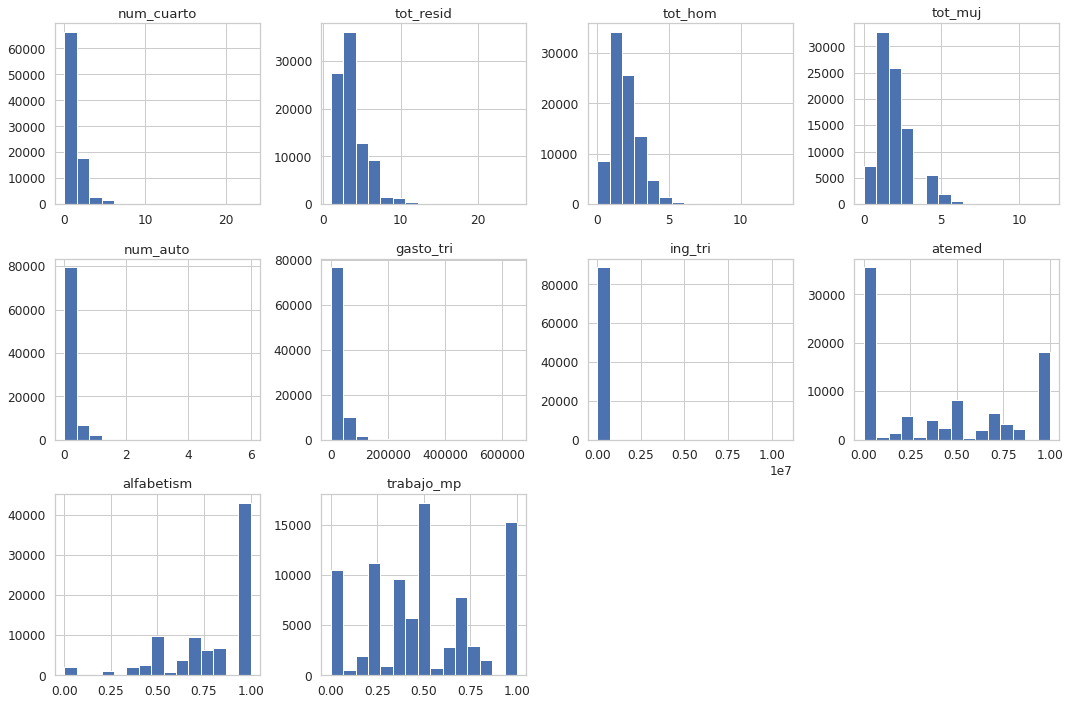

In [102]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
numerical.hist(bins=15, figsize=(18, 12), layout=(3, 4))

En las gráficas vemos que los hogares con número de autos por persona mayor que 2, o número de cuartos por persona mayor que 9 es extremadamente raro, en concreto: 

In [103]:
print((df['num_cuarto']>9).value_counts())
print((df['num_auto']>2).value_counts())

False    88986
True        20
Name: num_cuarto, dtype: int64
False    88986
True        20
Name: num_auto, dtype: int64


Además, el número de residentes total, hombres y mujeres en el hogar es raramente mayor que 15,8 y 9 respectivamente. Veamos la cantidad exacta de casos. 

In [104]:
print((df['tot_resid']>15).value_counts())
print((df['tot_hom']>8).value_counts())
print((df['tot_muj']>9).value_counts())

False    88978
True        28
Name: tot_resid, dtype: int64
False    88980
True        26
Name: tot_hom, dtype: int64
False    88977
True        29
Name: tot_muj, dtype: int64


Vamos entonces a eliminar estos valores extremos, ya que pueden ser muy perjudiciales para un modelo estadístico o de machine learning. Aquí hemos detectado estos valores "a ojo" y los eliminaremos, sin embargo, hay formas más sofisticadas de reconocerlos y tratarlos que se salen de los objetivos de este curso.
https://www.aprendemachinelearning.com/deteccion-de-outliers-en-python-anomalia/
https://brainfood.cl/casos_blog/manejo-de-outliers/
https://repository.upb.edu.co/bitstream/handle/20.500.11912/6582/T%C3%A9cnicas%20para%20detecci%C3%B3n%20de%20outliers%20multivariantes.pdf?sequence=1&isAllowed=y

In [105]:
df = df[df['tot_resid']<=15]
df = df[df['tot_hom']<=8]
df = df[df['tot_muj']<=9]
df = df[df['num_cuarto']<=9]
df = df[df['num_auto']<=2]

Veamos de nuevo las gráficas correspondientes: 

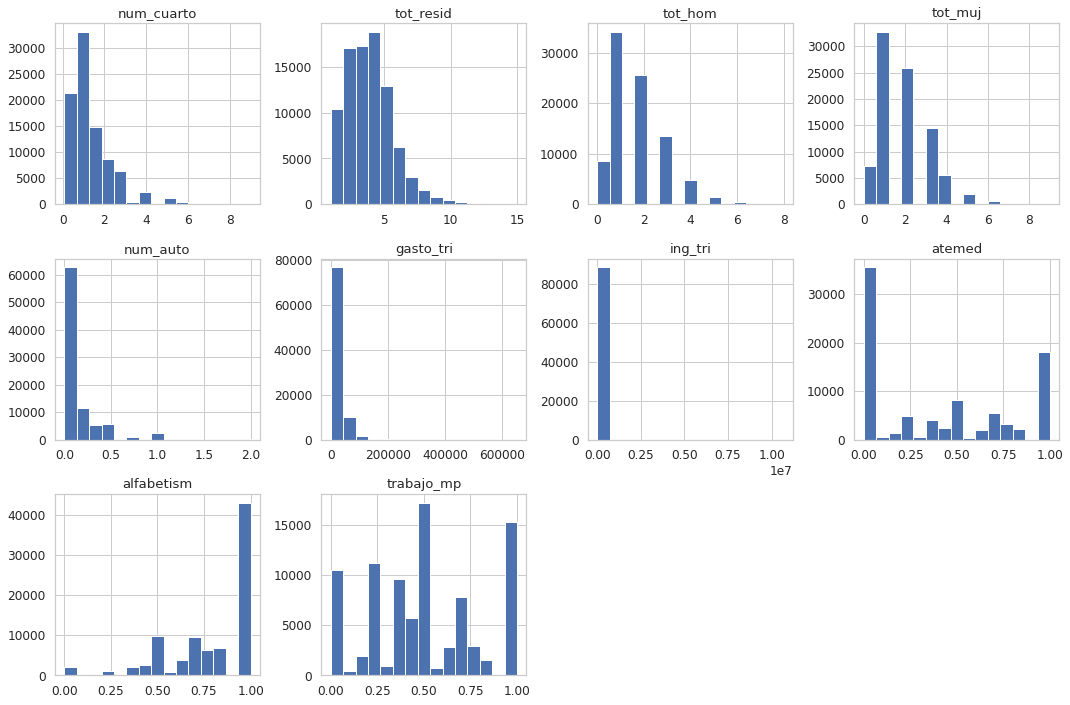

In [106]:
numerical = df.select_dtypes(include=np.number)
categorical = df.select_dtypes(exclude=np.number)
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
numerical.hist(bins=15, figsize=(18, 12), layout=(3, 4))
plt.show()

Ahora veamos con más detalle las columnas "ing_tri" y "gasto_tri" con ayuda de la función **jointplot** de seaborn, que grafica un gráfico de dispersión (scatter plot) de ambas variables y a ambos lados un histograma de cada una.  

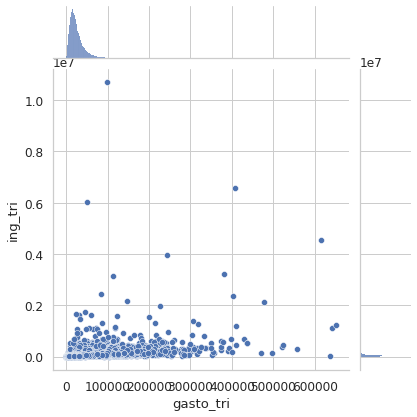

In [107]:
rcParams['figure.figsize'] = 15,8
sns.jointplot(x=df['gasto_tri'], y=df['ing_tri'])

Como vemos los valores mayores que 100,000 para los gastos trimestrales y los mayores que 300,000 para los ingresos trimestrales son raros. Concretamente:

In [108]:
print((df['gasto_tri']>100000).value_counts())
print((df['ing_tri']>300000).value_counts())

False    87497
True      1409
Name: gasto_tri, dtype: int64
False    88537
True       369
Name: ing_tri, dtype: int64


Como hicimos anteriormente eliminemos estos valores y volvamos a ver la gráfica.

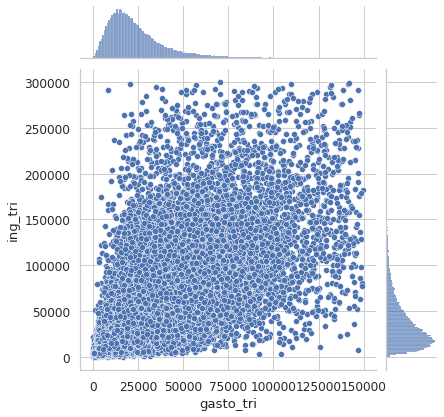

In [109]:
df = df[(df['gasto_tri'] <= 150000) & (df['ing_tri'] <= 300000)]
sns.jointplot(x=df['gasto_tri'], y=df['ing_tri'])

Observemos ahora, utilizando gráficas de barras, las variables categóricas.

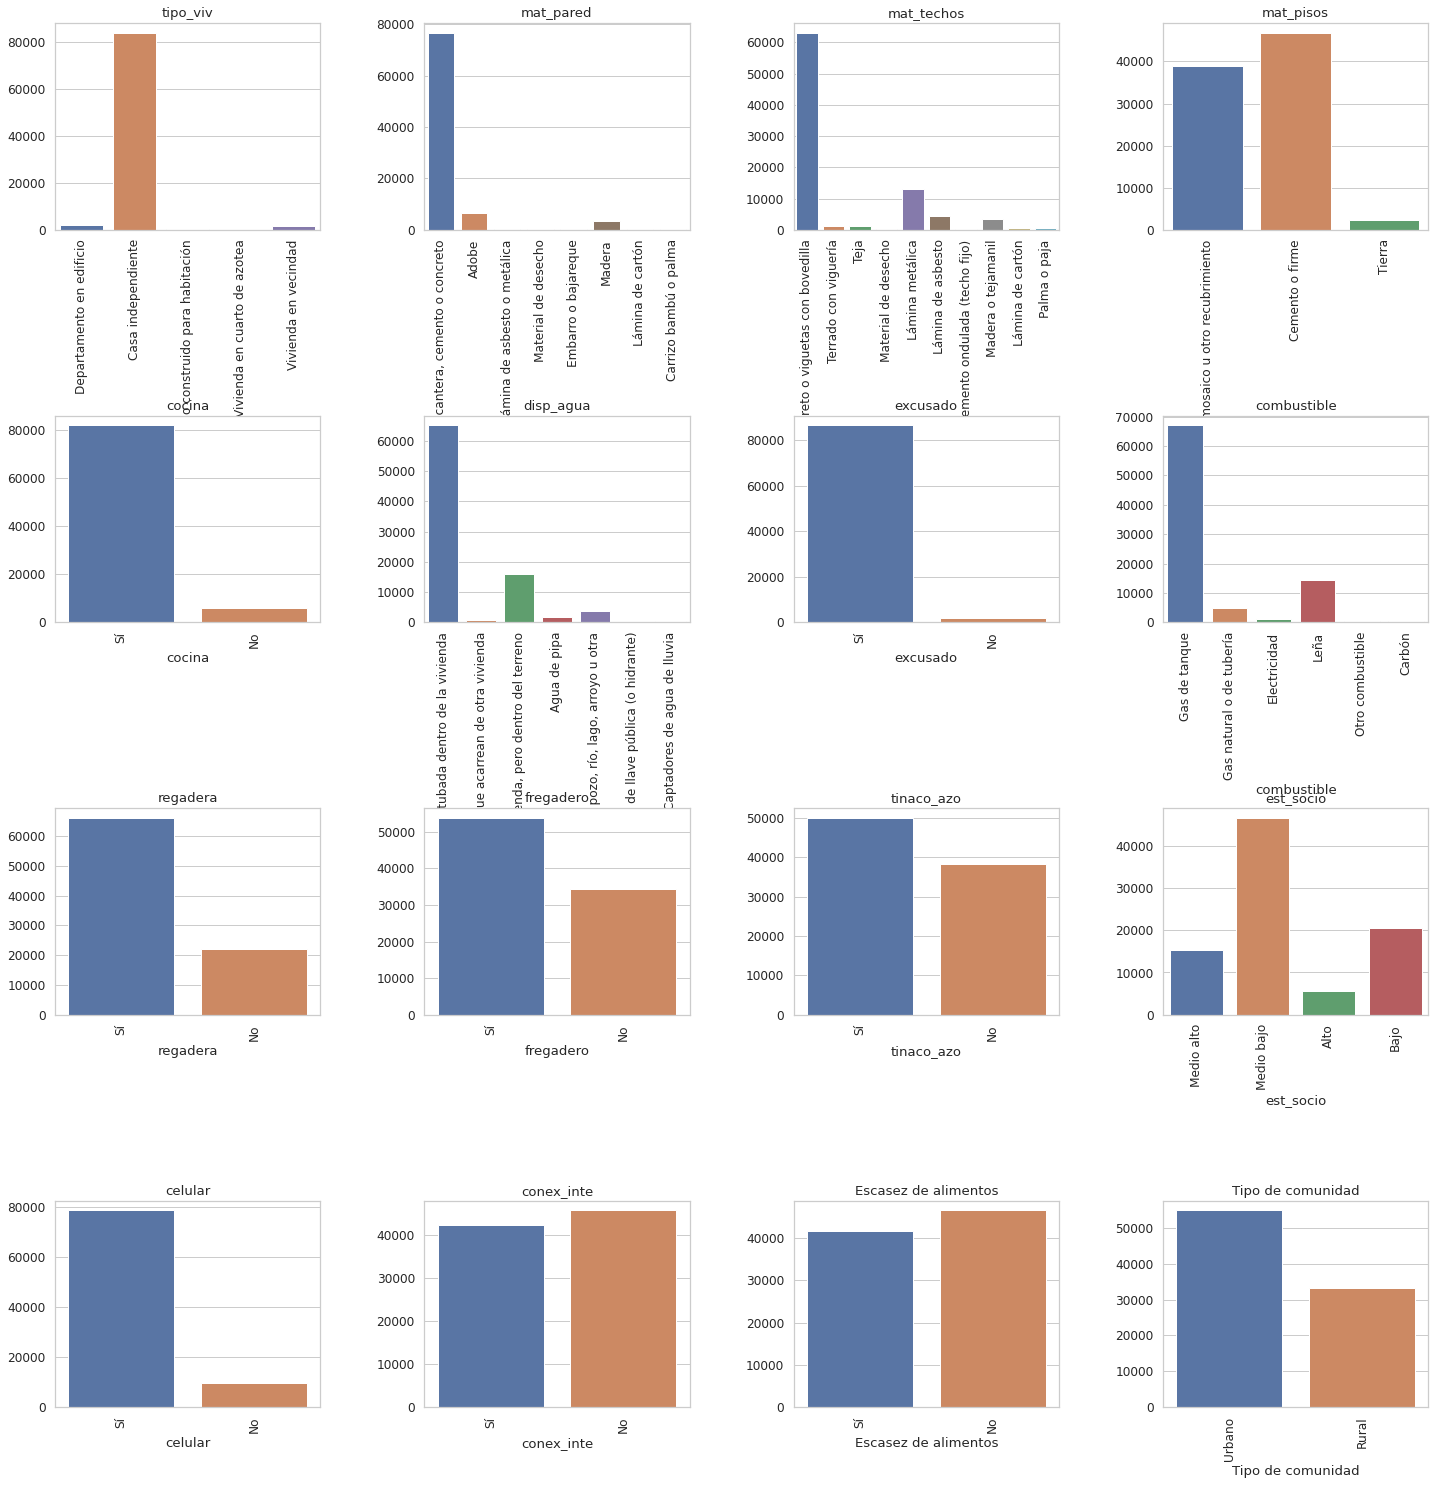

In [110]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
fig.tight_layout(h_pad=12, w_pad=5)
for variable, subplot in zip(categorical.columns, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    subplot.set_title(variable)
    subplot.set_ylabel('')
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Por último, por comodidad y mantener un formato, quisiéramos dejar al final la variable objetivo "est_socio", para hacer esto de forma sencilla utilizaremos un truco, sacaremos la variable de la lista de columnas con la función **remove** de las listas y la agregaremos nuevamente al final.

In [111]:
columns = df.columns.to_list()
columns.remove('est_socio')
df = df[columns + ['est_socio']]
df.to_csv('df_model.csv',index=False)